In [1]:
# Basic imports
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# Download data and create dataloaders
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# set up class labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import torch.nn as nn
import torch.nn.functional as F

# Define Model
class Net(nn.Module):
    def __init__(self, channels_1, channels_2, hidden_1, hidden_2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, channels_1, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(channels_1, channels_2, 5)
        self.fc1 = nn.Linear(channels_2 * 5 * 5, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define train config
config = {
    "model_init_kwargs": {
        "channels_1": 3,
        "channels_2": 8,
        "hidden_1": 64,
        "hidden_2": 32
    },
    "optimizer_init_kwargs": {
        "lr": 1e-3,
        "momentum": 0.9
    },
    "criterion": nn.CrossEntropyLoss
}

net = Net(**config["model_init_kwargs"])

In [4]:
import torch.optim as optim

# Define loss criterion
criterion = config["criterion"]()
# Define & configure optimizer
optimizer = optim.SGD(net.parameters(), **config["optimizer_init_kwargs"])

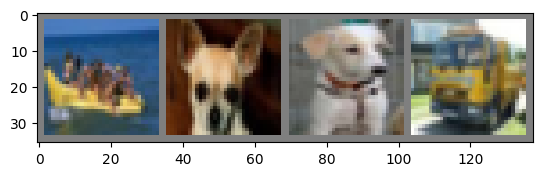

ship  dog   dog   truck


In [5]:
# Plot a few images from the dataset
import matplotlib.pyplot as plt
import numpy as np

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[lbl]:5s}' for lbl in labels))

In [6]:
# Main training loop

for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.235
[1,  4000] loss: 1.967
[1,  6000] loss: 1.783
[1,  8000] loss: 1.698
[1, 10000] loss: 1.655
[1, 12000] loss: 1.603
[2,  2000] loss: 1.573
[2,  4000] loss: 1.546
[2,  6000] loss: 1.503
[2,  8000] loss: 1.506
[2, 10000] loss: 1.492
[2, 12000] loss: 1.487
Finished Training


In [7]:
# Save the trained model
path_to_model = 'models/cifar10_model.pt'
torch.save(net, path_to_model)

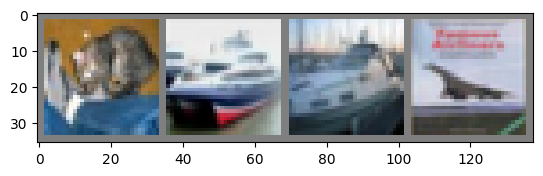

GroundTruth:  cat   ship  ship  plane
Predicted:  frog  ship  ship  plane


In [8]:
# Predictions on text set
dataiter = iter(testloader)
images, labels = next(dataiter)

outputs = net(images)
_, predicted = torch.max(outputs, 1)

# print images
imshow(torchvision.utils.make_grid(images))

print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

In [9]:
# Calculate accuracy of model on test set

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


correct = 0
total = 0
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    correct += correct_count
    total += total_pred[classname]
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

print(f'Total accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy for class: plane is 51.2 %
Accuracy for class: car   is 50.1 %
Accuracy for class: bird  is 41.5 %
Accuracy for class: cat   is 37.6 %
Accuracy for class: deer  is 25.2 %
Accuracy for class: dog   is 11.9 %
Accuracy for class: frog  is 75.2 %
Accuracy for class: horse is 59.9 %
Accuracy for class: ship  is 59.3 %
Accuracy for class: truck is 43.2 %
Total accuracy of the network on the 10000 test images: 45 %
